In [53]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skopt.space import Real, Categorical, Integer

from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.utils import get_dir

In [54]:
# Define the search space
search_spaces = {
    'condition_size': Integer(1, 2048),
    'model_nested_size': Integer(16, 1024),
    'model_nested_layers': Integer(1, 8),
    'model_n_blocks': Integer(4, 32),
    'model_act_norm': Categorical([True, False]),
    'model_dropout': Real(0.0, 0.5),
    'feature_network_hidden_size': Integer(16, 256),
    'feature_network_hidden_layers': Integer(0, 16),
    'feature_network_dropout': Real(0.0, 0.5),
}

In [55]:
checkpoint_file = os.path.join(get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_2", create=True), 'checkpoint_improved.pkl')
metrics_dir = get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_2", "metrics", create=True)

print(os.path.abspath(checkpoint_file))
print(os.path.abspath(metrics_dir))

/home/psaegert/Projects/bcnf/models/bcnf-models/hyperparameter_optimization/stage_2/checkpoint_improved.pkl
/home/psaegert/Projects/bcnf/models/bcnf-models/hyperparameter_optimization/stage_2/metrics


In [56]:
with open(checkpoint_file, 'rb') as f:
    checkpoint = pickle.load(f, errors='ignore')

In [57]:
metrics = {}
for metrics_file in os.listdir(metrics_dir):
    with open(os.path.join(metrics_dir, metrics_file), 'rb') as f:
        metrics[os.path.splitext(metrics_file)[0].replace('params_', '')] = pickle.load(f)

In [58]:
rows = [params + [value] for params, value in zip(checkpoint['x_iters'], checkpoint['func_vals'])]

In [59]:
hyper_df = pd.DataFrame(rows, columns=list(search_spaces.keys()) + ['val_loss_upper_bound'])

# Add the configuration name
hyper_df['configuration_name'] = hyper_df.apply(lambda row: "_".join([str(p) for p in row.values[:-1]]), axis=1)
hyper_df['val_loss_mean'] = hyper_df.apply(lambda row: np.mean([m['val_loss'][-1] for m in metrics[row['configuration_name']]]) if row['configuration_name'] in metrics else None, axis=1)
hyper_df['val_loss_std'] = hyper_df.apply(lambda row: np.std([m['val_loss'][-1] for m in metrics[row['configuration_name']]]) if row['configuration_name'] in metrics else None, axis=1)

# Set all columns in 'loss' that are = 100 to nan
hyper_df.loc[hyper_df['val_loss_upper_bound'] == 100, 'val_loss_upper_bound'] = None

# Round the values
hyper_df['model_dropout'] = hyper_df['model_dropout'].round(3)
hyper_df['feature_network_dropout'] = hyper_df['feature_network_dropout'].round(3)
hyper_df['val_loss_upper_bound'] = hyper_df['val_loss_upper_bound'].round(3)

In [60]:
len(hyper_df)

30

In [61]:
hyper_df.sort_values('val_loss_upper_bound')

,condition_size,model_nested_size,model_nested_layers,model_n_blocks,model_act_norm,model_dropout,feature_network_hidden_size,feature_network_hidden_layers,feature_network_dropout,val_loss_upper_bound,configuration_name,val_loss_mean,val_loss_std
6,769,240,3,28,True,0.231,101,5,0.130,-57.694,769_240_3_28_True_0.23076923076923078_101_5_0....,-57.988298,0.294259
10,641,389,2,17,True,0.385,157,8,0.217,-49.644,641_389_2_17_True_0.38461538461538464_157_8_0....,-52.409674,2.765669
9,1152,53,7,13,True,0.346,143,8,0.196,-48.787,1152_53_7_13_True_0.34615384615384615_143_8_0....,-49.264462,0.477379
18,577,91,6,21,True,0.195,31,15,0.391,-44.546,577_91_6_21_True_0.1952662721893491_31_15_0.39...,-46.347327,1.801701
25,1216,651,1,22,False,0.464,130,5,0.044,-38.046,1216_651_1_22_False_0.4644970414201184_130_5_0...,-38.477486,0.431442
23,1856,875,6,14,False,0.388,102,3,0.001,-34.855,1856_875_6_14_False_0.38757396449704146_102_3_...,-36.079669,1.224926
5,1280,800,1,24,False,0.192,87,4,0.109,-33.448,1280_800_1_24_False_0.19230769230769232_87_4_0...,-33.907283,0.459238
24,193,315,8,18,False,0.426,116,4,0.023,-32.547,193_315_8_18_False_0.4260355029585799_116_4_0....,-33.489936,0.943250
7,1792,576,4,5,True,0.269,115,6,0.152,-30.668,1792_576_4_5_True_0.2692307692307692_115_6_0.1...,-33.872554,3.204774
3,1536,128,5,16,False,0.115,58,3,0.065,-27.408,1536_128_5_16_False_0.11538461538461539_58_3_0...,-28.211227,0.802895


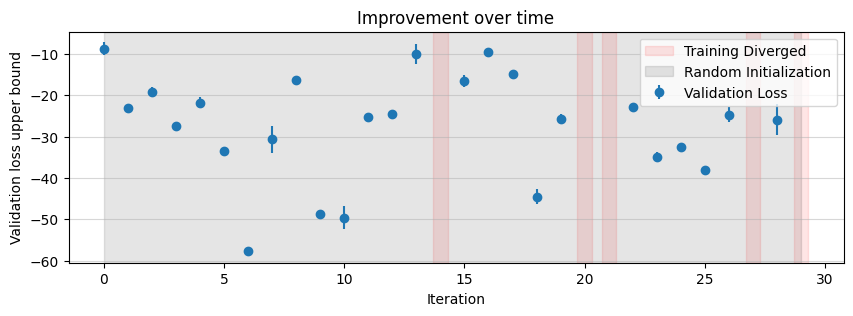

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.errorbar(hyper_df.index, hyper_df['val_loss_upper_bound'], yerr=hyper_df['val_loss_std'], fmt='o', label='Validation Loss')

# Plot nan values as red vertical lines
plotted_nan_values = False
for i, val in enumerate(hyper_df['val_loss_upper_bound']):
    if np.isnan(val):
        # ax.axvline(i, color='r', alpha=0.2, linestyle='--')
        ax.axvspan(i - 0.3, i + 0.3, color='r', alpha=0.1, label='Training Diverged' if not plotted_nan_values else None)
        plotted_nan_values = True

ax.axvspan(0, 29, color='k', alpha=0.1, label='Random Initialization')
ax.set_title('Improvement over time')
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation loss upper bound')
ax.grid(axis='y', alpha=0.5)
# ax.set_ylim(None, 30);

ax.legend()

In [63]:
# configuration = list(metrics.keys())[4]
# configuration = "1700_195_12_True_289_3_0.47366827208363227"
configuration = hyper_df.sort_values('val_loss_upper_bound').iloc[0]['configuration_name']

Text(0.5, 0.98, '769_240_3_28_True_0.23076923076923078_101_5_0.13043478260869565')

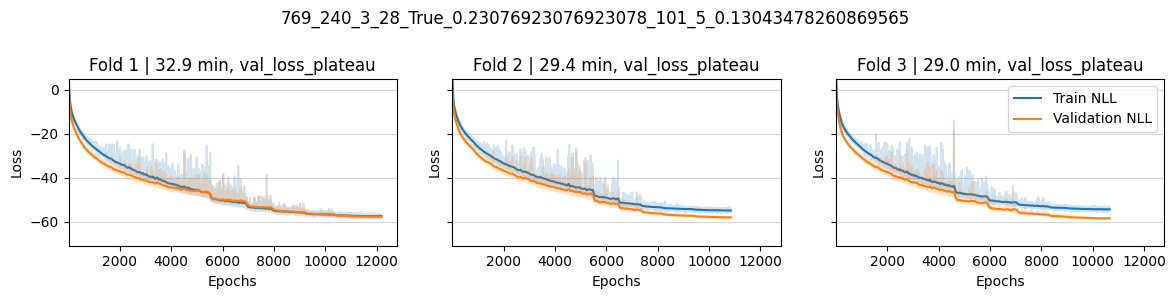

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    loss_history = metrics[configuration][i]['loss_history']
    epochs = np.array([e for e, _ in loss_history['train']])
    losses = np.array([l for _, l in loss_history['train']])

    ax.plot(epochs, losses, alpha=0.2, color='C0')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=128)), label='Train NLL', color='C0')

    epochs = np.array([e for e, _ in loss_history['val']])
    losses = np.array([l for _, l in loss_history['val']])

    ax.plot(epochs, losses, alpha=0.2, color='C1')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=32)), label='Validation NLL', color='C1')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

    # ax.set_xscale('log')
    ax.set_ylim(None, 5)
    ax.set_xlim(1, None)
    ax.grid(axis='y', alpha=0.5)

    time_taken = loss_history['time'][-1][1] - loss_history['time'][0][1]
    ax.set_title(f'Fold {i+1} | {time_taken / 60:.1f} min, {loss_history["stop_reason"]}')

axes[-1].legend();

fig.tight_layout()
fig.subplots_adjust(top=0.75)
fig.suptitle(configuration)

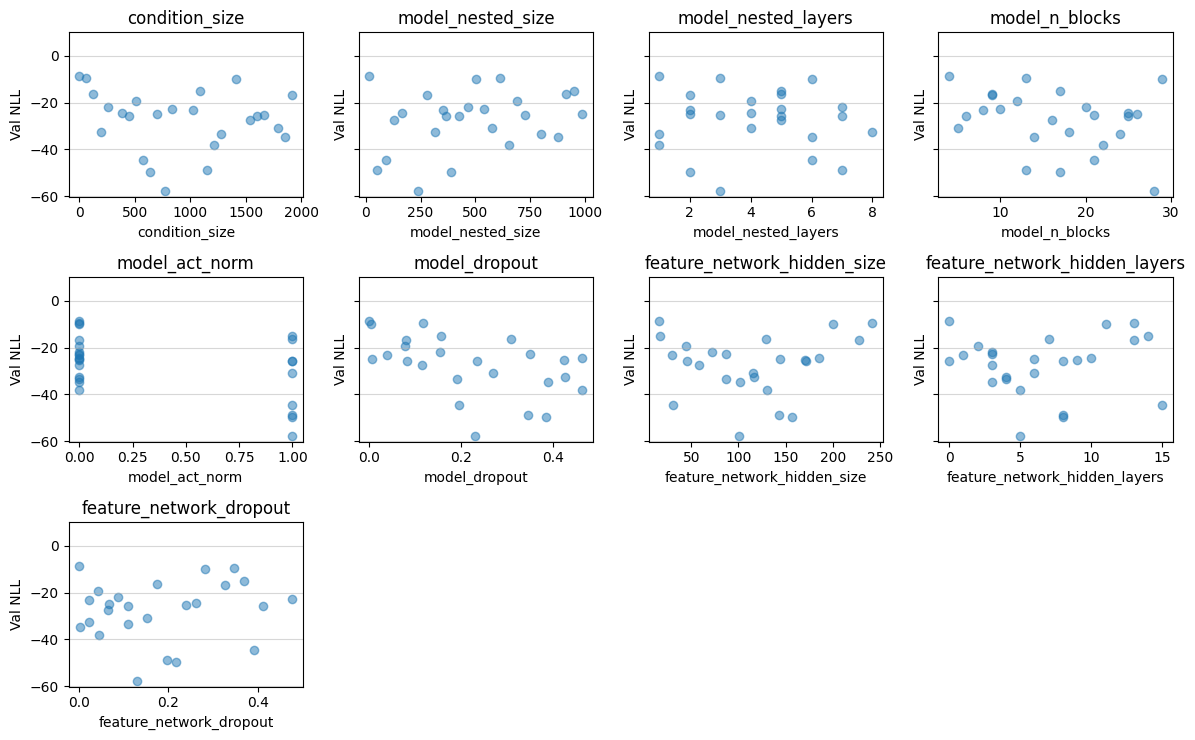

In [65]:
# Scatter the 'val_loss_upper_bound' column against the other columns
COLS = 4
ROWS = np.ceil(len(search_spaces) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2.5), sharey=True)

for i, (col, ax) in enumerate(zip(search_spaces.keys(), axes.flatten())):
    ax.scatter(hyper_df[col], hyper_df['val_loss_upper_bound'], alpha=0.5)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Val NLL')
    ax.grid(axis='y', alpha=0.5)
    ax.set_ylim(None, 10)

for ax in axes.flatten()[len(search_spaces):]:
    ax.remove()

fig.tight_layout()